# Monitoreo de Espacios Verdes - 2


### Idea, Secuencia y Suposiciones/Hipotesis

En este momento buscamos calcular ciertos estadisticos de las bandas de interes para cada roi de interes.

#### Suposiciones/Hipotesis

- Utilizamos solo la mascara de nubes provista por sentinel.

#### Idea

La idea consiste en caracterizar via algun estadistico el conjunto de puntos abarcado por cada parche para cada fecha disponible. El tamaño de cada parche es arbitrario asi como los estadisticos elegidos.
Esto nos va a permitir construir una serie temporal para un dado parche.

#### Secuencia

- Se procesa cada imagen y se genera un recorte sobre la ciudad en cuestion (parche)

- El parche obtenido se genera con cierto numero de bandas y se guarda.
    
- Las bandas que se utilizan se indica en el procesamiento y siempre corresponden con una resolucion de 10 m. En aquellos casos que la banda tenga menor resolucion se resamplea a 10 m.

- Una vez procesadas todas las imagenes satelitales (con la consecuente generacion de parches).Pasamos a la etapa de calculos de estadisticos sobre cada parche


**NOTA**: En esta jnb solo trabajaremos con una imagen mostrando la metodologia.


In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import geopandas as gpd
import os
import matplotlib.pyplot as plt
from rasterio.plot import plotting_extent
from earthpy import plot

#
from eo_forge.io.SentinelLoaders import Sentinel2Loader

#
import sys

sys.path.append("..")
from src.ioCalc import get_zonal_stats_indexes

Los datos concernientes a Córdoba capital los extraemos del set general de datos

In [2]:
gpd_cba = gpd.read_file("../data/cba/espacios-verdes-cba.gpkg")

In [3]:
gpd_cba.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 757 entries, 0 to 756
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   osm_id      757 non-null    object  
 1   fclass      757 non-null    object  
 2   name        191 non-null    object  
 3   cluster_id  757 non-null    float64 
 4   area_m2     757 non-null    float64 
 5   geometry    757 non-null    geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 35.6+ KB


<AxesSubplot:>

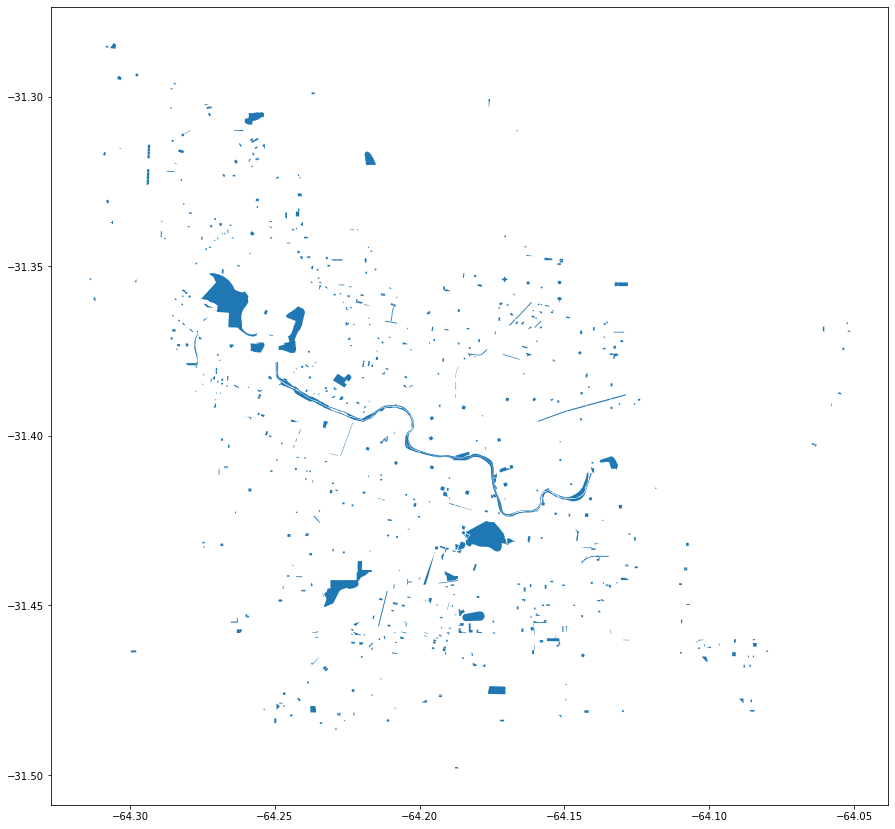

In [4]:
gpd_cba.plot(figsize=(15, 15))

La idea en lo que sigue es obtener la imagen satelital correspondiente a la zona y generar los parametros correspondientes (sin demasiada complejidad).

In [5]:
BASE_DIR = "../TMP-products-int"
os.makedirs(BASE_DIR, exist_ok=True)

In [6]:
# para cortar la imagen vamos a usar el bounding box generico de cordoba
gpd_box = gpd.read_file("../data/cba/cordoba.geojson")
BANDS = ["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B08", "B11", "B12"]
sl = Sentinel2Loader(
    "/data/sat-images/sentinel2/", bands=BANDS, resolution=10, bbox=gpd_box
)

2022/04/20 13:36:55 - INFO - Running on Sentinel 2 - l1c data


In [7]:
res_ = sl.execute(
    "S2B_MSIL1C_20210805T141739_N0301_R010_T20JLL_20210805T174126.SAFE",
    raster_return_open=True,
    write_file="_idx",
    folder_proc_=BASE_DIR,
)

2022/04/20 13:37:15 - INFO - Processing on /data/sat-images/sentinel2/S2B_MSIL1C_20210805T141739_N0301_R010_T20JLL_20210805T174126.SAFE dir
2022/04/20 13:37:15 - INFO - Using clipping flag: True
2022/04/20 13:37:15 - INFO - PROCESSING band: B02
2022/04/20 13:37:15 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/04/20 13:37:15 - INFO - checking  ROI
2022/04/20 13:37:15 - INFO - checking roi match - full match: True - area: 1
2022/04/20 13:37:15 - INFO - clipping with Tight BBox
2022/04/20 13:37:16 - INFO - calibrating band
2022/04/20 13:37:16 - INFO - reprojecting band
2022/04/20 13:37:16 - INFO - PROCESSING band: B03
2022/04/20 13:37:16 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/04/20 13:37:16 - INFO - checking  ROI
2022/04/20 13:37:16 - INFO - checking roi match - full match: True - area: 1
2022/04/20 13:37:16 - INFO - clipping with Tight BBox
2022/04/20 13:37:17 - INFO - calibrating band
2022/04/20 13:37:17 - INFO - reprojecting band
2022/04/20 

<AxesSubplot:>

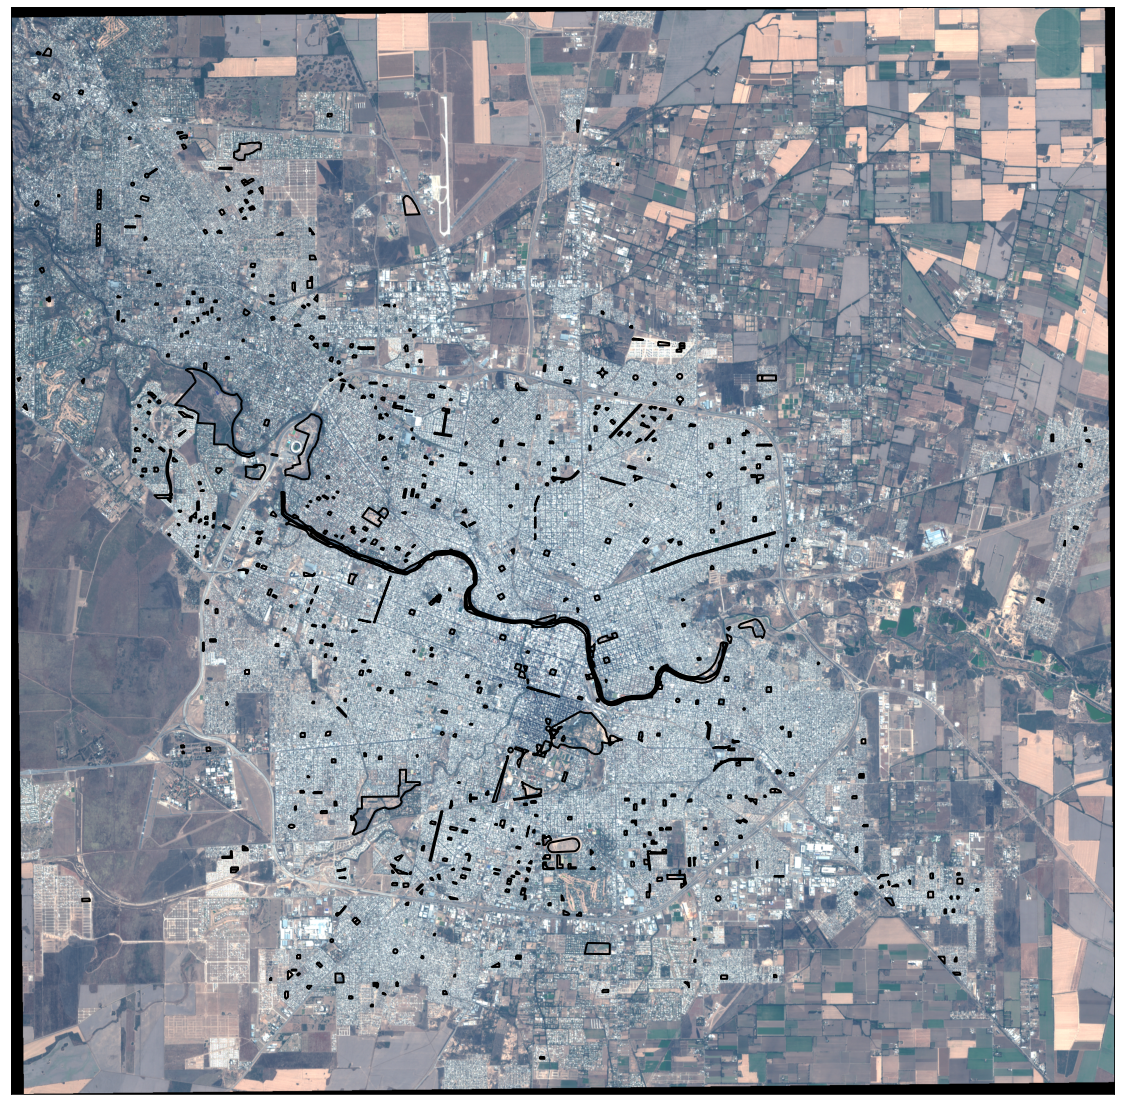

In [8]:
f, ax = plt.subplots(1, 1, figsize=(20, 20))
extent = plotting_extent(res_["raster"])
plot.plot_rgb(res_["raster"].read(), rgb=(2, 1, 0), ax=ax, extent=extent, stretch=True)
gpd_cba.to_crs(32720).plot(facecolor="None", edgecolor="k", lw=2, ax=ax)

In [9]:
gpd_cba.iloc[[0]]

,osm_id,fclass,name,cluster_id,area_m2,geometry
0,23300957,park,Plaza de las Américas,78.0,9134.445536,"POLYGON ((-64.19476 -31.43297, -64.19473 -31.4..."


In [10]:
get_zonal_stats_indexes(
    gpd_cba.iloc[[0]].to_crs(32720).geometry,
    res_["raster_path"],
    open_raster=True,
    close_raster=True,
)

{'B02_min': 0.10490000247955322,
 'B02_max': 0.2134999930858612,
 'B02_mean': 0.14266966701893324,
 'B02_count': 89,
 'B02_median': 0.13940000534057617,
 'B02_range': 0.10859999060630798,
 'B02_nodata': 0.0,
 'B03_min': 0.08259999752044678,
 'B03_max': 0.21639999747276306,
 'B03_mean': 0.13165618596452006,
 'B03_count': 89,
 'B03_median': 0.1281999945640564,
 'B03_range': 0.13379999995231628,
 'B03_nodata': 0.0,
 'B04_min': 0.07050000131130219,
 'B04_max': 0.24950000643730164,
 'B04_mean': 0.145626968212342,
 'B04_count': 89,
 'B04_median': 0.1412000060081482,
 'B04_range': 0.17900000512599945,
 'B04_nodata': 0.0,
 'B05_min': 0.10980000346899033,
 'B05_max': 0.2151000052690506,
 'B05_mean': 0.15719775939255617,
 'B05_count': 89,
 'B05_median': 0.1607999950647354,
 'B05_range': 0.10530000180006027,
 'B05_nodata': 0.0,
 'B06_min': 0.14270000159740448,
 'B06_max': 0.2460000067949295,
 'B06_mean': 0.18375619609704177,
 'B06_count': 89,
 'B06_median': 0.18529999256134033,
 'B06_range': 0.10

Entonces:
- elegimos una fecha
- generamos el recorte general
- calculamos los indices para cada uno de los rois dentro del recorte general
- unimos los datos
- seguimos con la fecha siguiente

Este esquema es para recopilacion y analisis de la evolución. Para monitoreo, necesitamos esta info y la ultima imagen satelital a la fecha. 

In [11]:
import dask
from dask.distributed import Client, progress
from dask.delayed import delayed

In [12]:
client = Client(n_workers=8, threads_per_worker=1, processes=True)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 62.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39647,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 62.65 GiB
Comm: tcp://127.0.0.1:46171,Total threads: 1
Dashboard: http://127.0.0.1:43537/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:43733,


In [13]:
stats_deayed = delayed(get_zonal_stats_indexes)

In [14]:
gpd_cba_crs = gpd_cba.to_crs(32720)
stats_ = []
for i, r in gpd_cba_crs.iterrows():
    geometry = r["geometry"]
    stats_.append(stats_deayed(geometry, res_["raster_path"], open_raster=True))

In [15]:
res_dask = dask.compute(stats_)

/home/frojo/miniconda3/envs/monitoreo-espacios-verdes/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/frojo/miniconda3/envs/monitoreo-espacios-verdes/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/frojo/miniconda3/envs/monitoreo-espacios-verdes/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/frojo/miniconda3/envs/monitoreo-espacios-verdes/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/frojo/miniconda3/envs/monitoreo-espacios-verdes/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarn

In [17]:
import pandas as pd

In [18]:
pd.DataFrame(res_dask[0])

,B02_min,B02_max,B02_mean,B02_count,B02_median,B02_range,B02_nodata,B03_min,B03_max,B03_mean,...,tcariOsavi_median,tcariOsavi_range,tcariOsavi_nodata,sipi_min,sipi_max,sipi_mean,sipi_count,sipi_median,sipi_range,sipi_nodata
0,0.1049,0.2135,0.142670,89,0.13940,0.1086,0.0,0.0826,0.2164,0.131656,...,0.153355,3.462574,0.0,0.542416,2.395350,1.122117,89,1.038161,1.852934,0.0
1,0.1090,0.2007,0.134328,146,0.13055,0.0917,0.0,0.0838,0.1911,0.115768,...,0.206111,8.177918,0.0,-0.083334,6.052625,0.716693,146,0.644320,6.135958,0.0
2,0.1049,0.1902,0.142381,167,0.14200,0.0853,0.0,0.0742,0.1809,0.130584,...,0.081763,5.959588,0.0,-7.321426,2.049080,1.029441,167,1.115880,9.370506,0.0
3,0.0972,0.1947,0.120467,51,0.11120,0.0975,0.0,0.0671,0.1842,0.099437,...,0.246815,22.077739,0.0,-242.995865,3.956521,-4.892051,51,0.376081,246.952386,0.0
4,0.0992,0.1560,0.128284,148,0.12985,0.0568,0.0,0.0696,0.1548,0.112880,...,0.182524,27.927433,0.0,-62.000111,1.592424,0.089999,148,0.795712,63.592535,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,0.1233,0.1689,0.136808,52,0.13125,0.0456,0.0,0.1135,0.1653,0.130288,...,0.214738,0.676340,0.0,1.029226,1.633846,1.230770,52,1.192974,0.604620,0.0
753,0.0990,0.1480,0.124792,95,0.12450,0.0490,0.0,0.0766,0.1456,0.113517,...,0.095775,0.804426,0.0,0.753340,1.512894,1.061074,95,1.009379,0.759554,0.0
754,0.1238,0.1824,0.156969,13,0.15990,0.0586,0.0,0.1063,0.1762,0.149069,...,0.158357,1.698909,0.0,0.851948,1.870879,1.258627,13,1.205128,1.018931,0.0
755,0.1400,0.1852,0.167215,111,0.16740,0.0452,0.0,0.1321,0.1908,0.170447,...,-0.006902,1.213388,0.0,1.106518,1.926298,1.584729,111,1.596302,0.819780,0.0


In [19]:
client.close()